# Running Classifiers 

For this script we will use a localizer dataset from Kim et al. (2017). For the localizer, subjects were shown faces, scenes and objects in 3 different runs.

**Pre-requisite** : You should be familiar with techniques outlined in the script from week 2: Loading fMRI data files into Python before running this script.

## Goal of this script
Using this script you will be able to use a classifier on your dataset. Specifically, we will accomplish the following:  
>1. Assign labels to every time-point (TR) in the dataset
>2. Time-shift the signal to be classified, taking into consideration the delayed hemodynamic response
>3. Collect BOLD data for all runs into one array
>4. Test out the following classifiers on a group of subjects with a fixed set of parameters:    
>    a. Gaussian Naive Bayes
>    b. Support Vector Machine
>5. Compute basic statistics to estimate means and confidence intervals         

By this stage, you should have completed motion correction and any other required pre-processing on the data. In this example, all the data has been pre-processed for you.

### First, we'll import all python packages that will be used in this script.
The following packages will be used:
            1. nibabel: Read  fMRI data into python arrays.  
            2. numpy: Perform numerical operations in python. 
            3. scipy: Scientific computing methods.  
            4. nilearn: Used to extract masked fMRI data from a Nifti file.
            5. sklearn: Machine Learning methods.  
            6. matplotlib: Plotting library (alternative to Bokeh)

In [1]:
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats

# We are using matplotlib for this exercise.
%matplotlib notebook
import matplotlib.pyplot as plt

try:
    from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
except:
    print('Running old version of brainiak. Code should still work')
    from brainiak.utils.fmrisim import double_gamma_hrf as hrf_func
    
# Import machine learning libraries
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV, cross_val_score, StratifiedKFold as skf, KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

Running old version of brainiak. Code should still work


### Load in the data 

As per the procedure used for the exercise in week 2, load in the vdc dataset. To load in the data we are going to first run a series of commands that set the variable name and then store the data. The timing data are stored as a matrix by concatenating all runs.

In [2]:
# Set the variables
dir = '/gpfs/milgram/data/cmhn-s18/datasets/vdc/'
sub = 'sub-01';

# Preset the variable size
stim_label = [];
stim_label_allruns = [];
for run in range(1,4):
    
    # Specify the input variables
    in_file= (dir + sub + '/ses-day2/design_matrix/' + "%s_localizer_0%d.mat" % (sub, run))

    # Load in data from matlab
    stim_label = scipy.io.loadmat(in_file);
    stim_label = np.array(stim_label['data']);

    # Store the data
    if run == 1:
        stim_label_allruns = stim_label;
    else:       
        stim_label_allruns = np.hstack((stim_label_allruns, stim_label))

print("Loaded ", sub)


Loaded  sub-01


Although we loaded the data above as a set of commands, this isn't an efficient way to code if we want to load in data again later because we would have to reuse those commands. A better way to code is to make a **function** that performs the loading of the data and then can be called with different input variables to load in new data. We do this below.

Functions are extremely useful for many reasons and so should be used everywhere: they allow you to remove redundancy in your code, reduce the likelihood of an error since if you update the function you update all of its uses, and you make your code much more readible.

A useful tutorial on functions is found [here](https://www.datacamp.com/community/tutorials/functions-python-tutorial).

One important thing to be aware of is how variables are shared between your workspace and a function. If you have variables in your workspace (i.e., any variables you have created in the usage of jupyter) then they will usually be accessible/usable in a function, regardless of whether they are used as input parameters. However, any variables you create in a function cannot be used in your workspace if you don't return them as outputs. For this reason it is easier if you keep the names of the variables in your function separate from the names in your workspace. This is turtles all the way down: if you have a function within a function then variables will be shared in the same way.

In [3]:
# Make a function for loading in the labels
def load_labels(directory, subject_name):
    stim_label = [];
    stim_label_concatenated = [];
    for run in range(1,4):
        in_file= (directory + subject_name + '/ses-day2/design_matrix/' + "%s_localizer_0%d.mat" % (sub, run))

        # Load in data from matlab
        stim_label = scipy.io.loadmat(in_file);
        stim_label = np.array(stim_label['data']);

        # Store the data
        if run == 1:
            stim_label_concatenated = stim_label;
        else:       
            stim_label_concatenated = np.hstack((stim_label_concatenated, stim_label))

    print("Loaded ", subject_name)
    return stim_label_concatenated


We now want to call this function and get it's outputs

In [4]:
# Load in the labels of the data
stim_label_allruns = load_labels(dir, sub)

Loaded  sub-01


### Label fMRI data

We want to assign every timepoint in the fMRI data a category label. This subject has 310 TRs but all others have 311. Some TRs will not have a label since there was no stimulus presented. 

Recall that the third row of the timing file is the start time of a trial in seconds since the start of the run. We can thus convert each time stamp to a specific TR by taking that time stamp and dividing by the TR duration (1.5 s). 

In [5]:
# Preset variables
_, events = stim_label_allruns.shape
num_runs=3
TR=1.5
TRs_run = 310
events_run = int(events / num_runs)

# Preset the array with zeros
stim_label_TR= np.zeros((TRs_run * 3, 1))

# Cycle through the runs
for run in range(0, num_runs):

    # Cycle through each element in a run
    for i in range(events_run):

        # What element in the concatenated timing file are we accessing
        time_idx = run * (events_run) + i

        # What is the time stamp
        time = stim_label_allruns[2, time_idx]

        # What TR does this timepoint refer to?
        TR_idx = int(time / TR) + (run * (TRs_run - 1))

        # Add the condition label to this timepoint
        stim_label_TR[TR_idx]=stim_label_allruns[0, time_idx]


**Exercise:** Below, make a function called 'label2TR' which performs the above steps described by taking in the inputs: num_runs, TR, TRs_run, events_run, to produce an output that specifies which condition label is assigned to each TR.

In [6]:
# Set up function
def label2TR(num_runs, TR, TRs_run, events_run):

    # Preset the array with zeros
    stim_label_TR_fun= np.zeros((TRs_run * 3, 1))

    # Cycle through the runs
    for run in range(0, num_runs):

        # Cycle through each element in a run
        for i in range(events_run):

            # What element in the concatenated timing file are we accessing
            time_idx = run * (events_run) + i

            # What is the time stamp
            time = stim_label_allruns[2, time_idx]

            # What TR does this timepoint refer to?
            TR_idx = int(time / TR) + (run * (TRs_run - 1))

            # Add the condition label to this timepoint
            stim_label_TR_fun[TR_idx]=stim_label_allruns[0, time_idx]
            
    return stim_label_TR_fun

In [7]:
# Run function
stim_label_TR = label2TR(num_runs, TR, TRs_run, events_run)

### Create a box car plot of the different conditions

Below we create a box car plot of the timing of different conditions for the first run. 

<IPython.core.display.Javascript object>


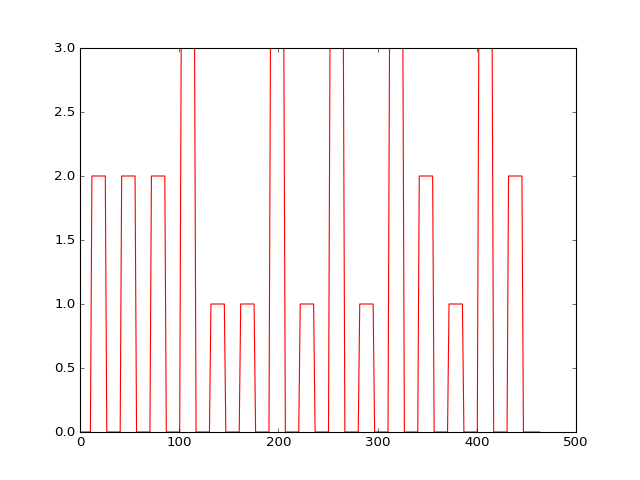

In [8]:
# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (TRs_run - 1) * 1.5 + 1, 1.5)

# Plot the data
plt.figure()
plt.plot(tr_time, stim_label_TR[0:TRs_run, 0], c='red')

**Exercise:** Add code to save the figure above into your repo (not locally).

In [9]:
plt.savefig('boxcar.png')

## Hemodynamic Lag: Time shift the labels

The brain response that we measure with fMRI is slow which means there is a lag between when events occur and when we expect to find changes in the BOLD signal. Below we plot the expected neural response to a single event.

<IPython.core.display.Javascript object>


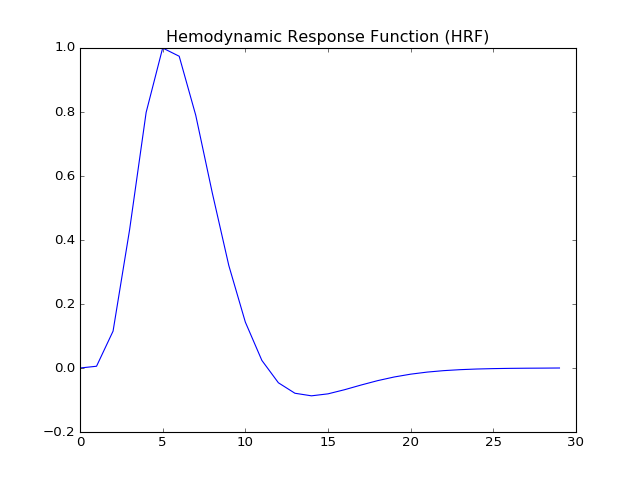

In [10]:
# Older versions of brainiak have different ways of calling this function
try:
    hrf = hrf_func(temporal_resolution=1)
except:
    # Create a function of the event time course that is 30 TRs long and an event occurs in the first TR
    stimfunction = [0] * 30
    stimfunction[0] = 1
    hrf = hrf_func(stimfunction, tr_duration=1, temporal_resolution=1)

# Plot the cannonical double gamma HRF
plt.figure()
plt.title("Hemodynamic Response Function (HRF)")
plt.plot(range(30), hrf)

**Self-study:** What does the expected neural response look like if two events evoke the same response, 5 seconds apart?

To account for the hemodynamic lag in neural responding we can shift the timecourse of events. First let's plot this timecourse.

<IPython.core.display.Javascript object>


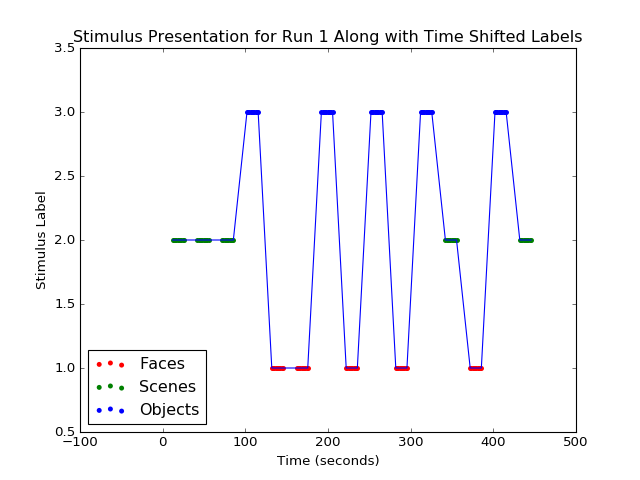

In [11]:
# Remake the plot from week 2
colormap = {1: "red",2: "green", 3: 'blue'}
label_key = {1: "Faces", 2: "Scenes", 3: "Objects"}

# Pull out the labels
face_idx = stim_label_allruns[0, :] == 1
object_idx = stim_label_allruns[0, :] == 2
scene_idx = stim_label_allruns[0, :] == 3

# Remove any time periods from other runs
face_idx[150:] = 0
object_idx[150:] = 0
scene_idx[150:] = 0

# Plot the figure
plt.figure()
plt.title("Stimulus Presentation for Run 1 Along with Time Shifted Labels")
plt.plot(stim_label_allruns[2, 0:150], stim_label_allruns[0, 0:150])

# Because the legend we want to make is based on values, one way you can do this in matplotlib is to create as many plots as there are conditions
h1 = plt.scatter(stim_label_allruns[2, face_idx], stim_label_allruns[0, face_idx], c=colormap[1], lw = 0)
h2 = plt.scatter(stim_label_allruns[2, object_idx], stim_label_allruns[0, object_idx], c=colormap[2], lw = 0)
h3 = plt.scatter(stim_label_allruns[2, scene_idx], stim_label_allruns[0, scene_idx], c=colormap[3], lw = 0)
plt.legend([h1, h2, h3], list(label_key.values()), loc="lower left")
plt.xlabel('Time (seconds)')
plt.ylabel('Stimulus Label')


**Exercise:** Make another plot like above except that the Y tick labels specify the condition.

<IPython.core.display.Javascript object>


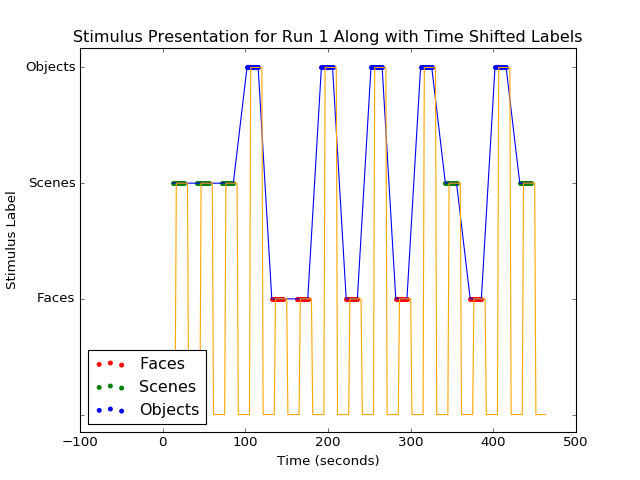

([<matplotlib.axis.YTick at 0x2b0f0f49f748>,
 <a list of 4 Text yticklabel objects>)

In [12]:
plt.figure()
plt.title("Stimulus Presentation for Run 1 Along with Time Shifted Labels")
plt.plot(stim_label_allruns[2, 0:150], stim_label_allruns[0, 0:150])

# Because the legend we want to make is based on values, one way you can do this in matplotlib is to create as many plots as there are conditions
h1 = plt.scatter(stim_label_allruns[2, face_idx], stim_label_allruns[0, face_idx], c=colormap[1], lw = 0)
h2 = plt.scatter(stim_label_allruns[2, object_idx], stim_label_allruns[0, object_idx], c=colormap[2], lw = 0)
h3 = plt.scatter(stim_label_allruns[2, scene_idx], stim_label_allruns[0, scene_idx], c=colormap[3], lw = 0)
plt.legend([h1, h2, h3], list(label_key.values()), loc="lower left")
plt.xlabel('Time (seconds)')
plt.ylabel('Stimulus Label')

plt.yticks( range(4), ('','Faces', 'Scenes', 'Objects') )

We need to incorporate this time-shift when we extract the BOLD signal for classification. One way to accomplish this is to shift the labels by 4-5 seconds and extract the BOLD signal for the non-zero labels. As one TR = 1.5 seconds, we'll shift by 3 TRs.

In [13]:
# Shift the data a certain amount
hrf_lag = 4.5  # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(hrf_lag / TR) # Convert the shift into TRs

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top.
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line.
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

In [14]:
# Add the boxcar to the plot
plt.plot(tr_time, stim_label_TR_shifted[0:310], c='orange')

Note how the shifted boxcar is not plotted automatically into the cell above. This is because plotting goes into the figure after plt.figure() was called and will keep writing there (automatically sets 'hold on' if you are familiar with matlab) until you call a new plt.figure().

## Load the fMRI data.

As in the exercise from week 2 we will load in, mask, and z-score the data

In [15]:
# Load data files for one run of the localizer.

masks = ['FFA']

# Make a function to load the mask data
def load_mask_data(directory, subject_name, mask_list):
    
    masked_data_all = [0] * len(mask_list)
    maskdir = (directory + subject_name + "/preprocessed/masks/")
    
    # Cycle through the masks
    for mask_counter in range(len(mask_list)):
        print ("Processing Start ...")
        maskfile = (maskdir + "%s_ventral_%s_locColl_to_epi1.nii.gz" % (subject_name, mask_list[mask_counter]))

        mask = nib.load(maskfile)
        print ("Loaded Mask")

        # Cycle through the runs
        for run in range(1, num_runs + 1):
            epi_in = (directory + subject_name + "/preprocessed/loc/%s_filtered2_d1_firstExampleFunc_r%d.nii" % (subject_name, run))
            print(epi_in)

            # Load in the fmri data
            epi_data = nib.load(epi_in)
            nifti_masker = NiftiMasker(mask_img=mask)
            epi_mask_data = nifti_masker.fit_transform(epi_data);

            # Transpose and Z-score (Standardize) the data  
            epi_mask_data = np.transpose(epi_mask_data)
            scaler = preprocessing.StandardScaler().fit(epi_mask_data)
            maskedData_zscore =  scaler.transform(epi_mask_data)
            if run == 1:
                masked_data_all[mask_counter] = maskedData_zscore
            else:
                masked_data_all[mask_counter] = np.hstack((masked_data_all[mask_counter], maskedData_zscore))
                
    # Return the list of mask data
    return masked_data_all

# Pull out the mask data
epi_mask_data_all = load_mask_data(dir, sub, masks)

Processing Start ...
Loaded Mask
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii


In [16]:
# Check the dimensionality of the data
print(epi_mask_data_all[0])
print(stim_label_TR_shifted.shape)

[[ 2.68163681  2.57479429  2.38122797 ...,  2.43999958  2.65115952
   2.5479064 ]
 [ 2.87856483  2.72829437  2.57561278 ...,  2.63578653  2.48103189
   2.38436675]
 [ 2.34251881  2.18468928  2.15250945 ...,  1.8544786   1.90331364
   1.76841497]
 ..., 
 [ 1.17770648  1.14735842  1.34937716 ...,  1.73894882  1.73092401
   1.72176397]
 [ 1.70008802  1.77719271  1.46204996 ...,  1.89145792  1.95416057
   1.98932123]
 [ 0.69162703  0.8111372   0.7507143  ...,  0.89921063  0.86620885
   0.85400587]]
(930,)


## Classification

We will now build a very basic classifier to categorize our data. We will try two classifier algorithms that you learned about in class.

Each classifier has a number of parameters that can be changed to affect the sensitivity of the classification. For now, we will hard code these parameters but in the future we will cover more principled ways to do classification in a future exercise.

First we extract the time points for which we have stimulus labels -- i.e., we drop the time-points from the BOLD signal that refer to the baseline condition.

In [17]:
# Extract bold data for non-zero labels.
def reshape_data(label_TR_shifted, masked_data_all):
    label_index = np.nonzero(label_TR_shifted)
    label_index = np.squeeze(label_index)
    
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_all[:,label_index])
    nonzero_labels = label_TR_shifted[label_index] 
    
    return indexed_data, nonzero_labels

bold_data, labels = reshape_data(stim_label_TR_shifted, epi_mask_data_all[0])

# What is the dimensionality of the data? We need the first dim to be the same
print(bold_data.shape)
print(labels.size)

(450, 5519)
450


**Self-study:** Exclusion is not the only way we can deal with 'rest' time points. We could use them as a reference, such as for baselining (e.g., subtraction, percent change) or even as a 'category' in the classifier.

Next, we split the data into training and test sets. Remember the cardinal rule of classification: the training and test datasets should **NEVER** be mixed. First we are going to show you a case where this cardinal rule is broken: we train our classifer on all of the data and then test on a subset (this is like taking a quiz after you have already been shown the answers).

In [18]:
#Specify the classifiers that will be used
classifier = SVC(kernel="linear", C=1, probability=True)  

# Set up the procedure for splitting the data
n_folds = 3  # How many times will you carve up the data into different training and test sets
skfold = skf(n_splits=n_folds) 
print(skfold)

# Split the data
cv_score = np.array([])
for train, test in skfold.split(bold_data, labels):

    # Pull out the training and test data (BUT DO IT WRONG)
    training_data = bold_data[np.append(train, test)] # NO, NO, NO, NO, NO
    training_labels = labels[np.append(train, test)] # NO, NO, NO, NO, NO
    testing_data = bold_data[test]
    testing_labels = labels[test]

    # Train the model
    clf = classifier.fit(training_data, training_labels) 

    # Test the model on new data
    score = clf.score(testing_data, testing_labels)

    # Store the result
    cv_score = np.hstack((cv_score, score))

# Summarise the results of the classifier                             
print('Classifier Results: ', cv_score)
print("Accuracy cross-val (CI-95): %0.2f, (+/- %0.2f)" % \
      (cv_score.mean(), cv_score.std() * 2)) 

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
Classifier Results:  [ 1.  1.  1.]
Accuracy cross-val (CI-95): 1.00, (+/- 0.00)


**Exercise:** Briefly explain what the fit and score functions are doing:

**A:** Fit is a method (defined in sklearn) that attempts to fit a model (in this case, an SVM) to the data. It takes as input the training data (a matrix, i.e. a set of vectors) and the target values (a vector of class labels, in this case), and outputs itself (i.e. a fitted model).

The score function returns the mean accuracy on the given test data and labels, i.e. the performance of the model. 

Now do it the correct way by using DIFFERENT time points for training and test. We should expect the accuracy to decrease substantially because we no longer are cheating.

In [19]:
def call_classifiers(bold_data, labels):

    #Specify the classifiers that will be used
    classifiers = [
        SVC(kernel="linear", C=1, probability=True),
        GaussianNB()] 

    n_folds = 3

    # Set up the procedure for splitting the data
    skfold = skf(n_splits=n_folds) 

    # Decide what the classifier is 
    for classifier in classifiers:

        print('Running classifier: ', classifier, '\n')
        # initialize arrays.
        cv_score = np.array([])

        # Split the data
        for train, test in skfold.split(bold_data, labels):

            # Pull out the training and test data
            training_data = bold_data[train]
            training_labels = labels[train]
            testing_data = bold_data[test]
            testing_labels = labels[test]

            # Train the model
            clf = classifier.fit(training_data, training_labels) 

            # Test the model on new data
            score = clf.score(testing_data, testing_labels)

            # Store the result
            cv_score = np.hstack((cv_score, score))
         
        if classifier == classifiers[0]:
            svm_mean = cv_score.mean()
        else: gnb_mean = cv_score.mean()
            
        # Summarise the results of the classifier                             
        print('Classifier Results: ', cv_score)
        print("Accuracy cross-val (CI-95): %0.2f, (+/- %0.2f)\n\n" % \
              (cv_score.mean(), cv_score.std() * 2))
        
    return svm_mean, gnb_mean

**Exercise:** Is this good performance? What would you expect by chance? How could you prove that by changing one line of code above (no need to implement the proof)?

This is fairly good performance, i.e. both means are 62%, and there are 3 possible classes. Naively, this implies that chance performance should be around 1/3 or 33%, and the lower bounds of the confidence intervals are well above this threshold. However, this threshold might not hold true if e.g. there weren't equal numbers of each class type. So, to prove that chance performance is indeed 33%, you could just shuffle the class labels,  run the model again, and see what you get. In practice, you'd want to perform this shuffle procedure many times and compare mean performance of the true model with the entire distribution of shuffle performances.

**Exercise:** In this analysis, are there concerns about the independence of observations? If so, why?

Gaussian Naive Bayes (GNB) assumes a diagonal covariance matrix among all voxels and then tries to fit a Gaussian distribution (mean and variance) for each class. Thus, GNB assumes that all voxels are independent of one another. This is of course not literally true: there is widespread connectivity across virtually all brain regions.

Furthermore, each observation might not be fully independent, which would affect both the SVM and GNB. There are at least two possible reasons for this. First, each image was presented 5 seconds apart, which is not enough time for the HRF to return to baseline (as plotted above). Second, adaptation/habituation effects could occur (this is a common observation in fMRI), such that later observations produce a lower BOLD response. This is perhaps the most pressing concern about independence, because it will add noise (i.e. it will make the cloud of responses for each class more variable).

### Perform the analysis across participants

The next step is to run a classifer on a group of subjects. We will now create the condition variable, stim_label_TR, for all subjects and then use it to pull out the relevant participant data and then feed it into a classifier.

Before you run this command, make sure you save your notebook. You will be loading in a lot of data and so it might run into memory issues and crash your job. If you do have issues, change how much memory you request in your run_jupyter.sh script.

**Exercise:** The code below loops through subjects but the classifier calls are missing (at the bottom). Convert the classifier code above into a function, call the function below, save your notebook, and then run the code.

In [20]:
svm_means = np.array([])
gnb_means = np.array([])

# Cycle through the participants
for sub_id in range(1,20):
    
    # Convert the number into a participant folder name
    if (sub_id < 10):
        sids = '0' + str(sub_id)
    else:
        sids = str(sub_id)   
    
    # Specify the subject name
    sub = 'sub-' + sids
    
    # Load subject labels
    stim_label_allruns = load_labels(dir, sub)

    # Load the fMRI data
    masks = ['FFA']
    epi_mask_data_all = load_mask_data(dir, sub, masks)

    # Already preset from above
    #_, events = stim_label_allruns.shape
    #num_runs=3
    #TR=1.5
    #events_run = int(events / num_runs)
    #hrf_lag = 4.5  # In seconds what is the lag between a stimulus onset and the peak bold response
    #shift_size = int(hrf_lag / TR) # Convert the shift into TRs

    # This can differ per participant
    print('TRs for ', sub, ':', epi_mask_data_all[0].shape[1])
    TRs_run = int(epi_mask_data_all[0].shape[1] / num_runs)

    # Convert the timing into TR indexes
    stim_label_TR = label2TR(num_runs, TR, TRs_run, events_run)

    # Shift the data some amount
    stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

    # Perform the reshaping of the data
    bold_data, labels = reshape_data(stim_label_TR_shifted, epi_mask_data_all[0])

    # Add code here for running the classification
    svm_mean_i, gnb_mean_i = call_classifiers(bold_data, labels)
    
    svm_means = np.hstack((svm_means, svm_mean_i))
    gnb_means = np.hstack((gnb_means, gnb_mean_i))

print("Mean SVM cross-val (CI-95): %0.2f, (+/- %0.2f)\n\n" % \
    (svm_means.mean(), svm_means.std() * 2))
print("Mean GNB cross-val (CI-95): %0.2f, (+/- %0.2f)\n\n" % \
    (gnb_means.mean(), gnb_means.std() * 2))

Loaded  sub-01
Processing Start ...
Loaded Mask
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
TRs for  sub-01 : 930
Running classifier:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Classifier Results:  [ 0.67333333  0.47333333  0.72666667]
Accuracy cross-val (CI-95): 0.62, (+/- 0.22)


Running classifier:  GaussianNB(priors=None) 

Classifier Results:  [ 0.67333333  0.64        0.54      ]
Accuracy cross-val (CI-95): 0.62, (+/- 0.11)


Loaded  sub-02
Processing Start ...
Loaded Mask
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-02/

**Exercise:** What is the average accuracy across participants of the GNB and SVM classifiers?

I made my call_classifiers function return the individual means, and then I averaged them together at the end of the previous script and printed them out. For the SVM, the average accuracy across participants is 0.66 (SD = 0.22). For the GNB, it is 0.59 (SD = 0.21). Both are well above 1/3, even at the lower bound.

NB: this is only for subjects 1-19 (per Slack guidance), as the data for subject 20 was corrupted. 

**Novel contribution:** be creative and make one new discovery by adding an analysis, visualization, or optimization.


<IPython.core.display.Javascript object>


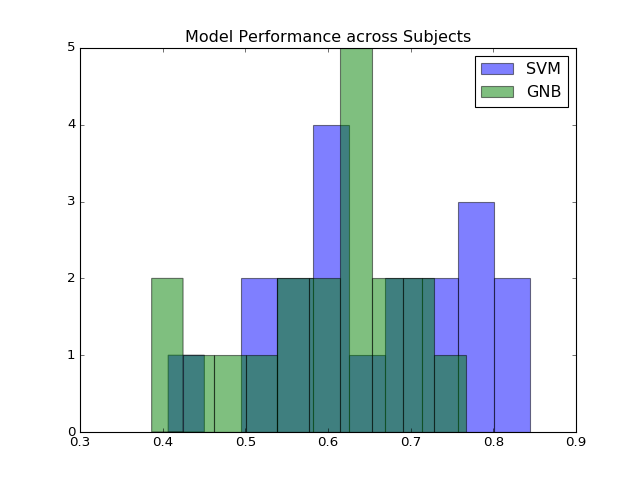

In [21]:
#visualize the distribution of model performance for each subject, separate for SVM and GNB distributions, on a single plot
plt.figure()
plt.title("Model Performance across Subjects")

#bins = numpy.linspace(-10, 10, 100)

plt.hist(svm_means, alpha=0.5, label='SVM')
plt.hist(gnb_means, alpha=0.5, label='GNB')
plt.legend(loc='upper right')
plt.show()